In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional, Input
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


Step 1:-Loading the dataset. Here the dataset used is of airline-passenger which is a time-series forecasting database.

In [ ]:

url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = pd.read_csv(url, parse_dates=['Month'], index_col='Month')


We use pandas' read_csv function to read in the data, informing it that the 'Month' column represents dates and should be utilized as the index for the DataFrame.


Step 2: Data Preprocessing

In [ ]:

data = df[['Passengers']]  # Selecting the target column
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)  # Normalize data


Here only the passenger column is selected for modeling, and using minmaxscaler, the data is scaled from 0 to 1 as it is useful for neural network since it can work better when the input features are in a small range. 

Step 3: Create Sequences for LSTM Input

In [ ]:
# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 12  # 12 months of data to predict the next month's value
X, y = create_sequences(data_scaled, seq_length)


Here, we are preparing the data for the LSTM model by creating sequences. We are taking 12 months' worth of historical data as input and training the model to output the value of the subsequent month, so it learns temporal patterns.

Step 4: Train/Test Split-splitting the data into training and testing sets(80% train,20% test)

In [ ]:

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


The data is split into testing and training sets.It helps in enhancing the performance of the model.

Step 5: Reshaping Data for matching with the LSTM input requirements(samples, time steps, features)

In [ ]:

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


We reshape the training and test data to 3D format (samples, time steps, features) so that the LSTM model can accept time-series sequences as input in a proper manner.

Step 6: Define LSTM & BiLSTM Model Function

In [ ]:
def build_model(model_type='LSTM', units=100, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(seq_length, 1)))  # Input layer

    if model_type == 'LSTM':
        model.add(LSTM(units, activation='relu', return_sequences=True))
    else:  # BiLSTM
        model.add(Bidirectional(LSTM(units, activation='relu', return_sequences=True)))

    model.add(Dropout(dropout_rate))
    
    if model_type == 'LSTM':
        model.add(LSTM(units, activation='relu'))
    else:
        model.add(Bidirectional(LSTM(units, activation='relu')))

    model.add(Dropout(dropout_rate))
    model.add(Dense(1))  

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model


The build_lstm_model() and build_bilstm_model() functions create two different deep learning models for predicting time-series data. The LSTM model is two LSTMs with ReLU activation, followed by dropout layers to prevent overfitting, and a dense prediction layer. The BiLSTM model adds the use of bidirectional LSTM layers, which learn about past and future sequence relationships, for better predictions. The models are validated and trained using both compiled with Adam optimizer and the MSE loss function, ensuring optimized computation and learning.

Step 7: Train the Models

In [ ]:

model_lstm = build_model(model_type='LSTM', units=50, dropout_rate=0.2, learning_rate=0.001)
history_lstm = model_lstm.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), verbose=1)


model_bilstm = build_model(model_type='BiLSTM', units=100, dropout_rate=0.5, learning_rate=0.01)
history_bilstm = model_bilstm.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), 
verbose=1)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 425ms/step - loss: 0.1295 - val_loss: 0.4415
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.1132 - val_loss: 0.4101
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.1017 - val_loss: 0.3824
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0987 - val_loss: 0.3560
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.0854 - val_loss: 0.3296
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0787 - val_loss: 0.3011
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0640 - val_loss: 0.2696
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.0635 - val_loss: 0.2342
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0453 - val_loss: 0.1944
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.0383 - val_loss: 0.1490
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0272 - val_loss: 0.1008
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0191 - val_loss: 0.05

Step 7 trains the LSTM model with the training set for 50 epochs with a batch size of 64. The model updates its weights and learns to decrease prediction errors. It employs a validation set in order to gauge performance after each epoch to ensure that the model does not overfit and will generalize well.
While the BiLSTM model had a training set of 100 epochs with higher dropout rate of 0.5 and higher learning rate of 0.01.

Step 8: Plot Training and Validation Loss

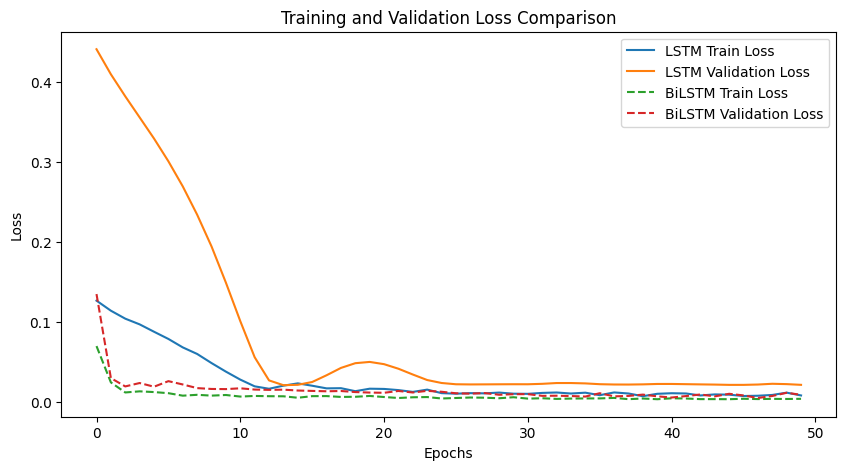

In [ ]:

plt.figure(figsize=(10, 5))
plt.plot(history_lstm.history['loss'], label='LSTM Train Loss')
plt.plot(history_lstm.history['val_loss'], label='LSTM Validation Loss')
plt.plot(history_bilstm.history['loss'], label='BiLSTM Train Loss', linestyle='dashed')
plt.plot(history_bilstm.history['val_loss'], label='BiLSTM Validation Loss', linestyle='dashed')
plt.title('Training and Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Compares LSTM and BiLSTM performance using loss curves.

a)The BiLSTM model appears better than the LSTM model because it has a lower validation loss, hence better generalizing to unseen data.

b)The LSTM model is slightly overfitted as its validation loss is higher than its training loss towards later epochs.

c)Both models stabilize at about 20 epochs with no further improvement.

Step 9: Save the models

In [ ]:

model_lstm.save('lstm_model_tuned.keras')
model_bilstm.save('bilstm_model_tuned.keras')


Saves both models

Step 10: Compare Final Validation Losses

In [ ]:

final_lstm_loss = history_lstm.history['val_loss'][-1]
final_bilstm_loss = history_bilstm.history['val_loss'][-1]

print(f"Final Validation Loss - LSTM: {final_lstm_loss}")
print(f"Final Validation Loss - BiLSTM: {final_bilstm_loss}")


Final Validation Loss - LSTM: 0.021009696647524834
Final Validation Loss - BiLSTM: 0.008518490940332413


Prints the final loss for each model.

a)The BiLSTM model is better than the LSTM model since it has a significantly lesser validation loss.

b)This is an indication that bidirectional processing enables the BiLSTM model to learn more by considering both future and past contexts.

c)Lesser loss in BiLSTM suggests good generalization and points to it being the preferred model for airline passenger trend prediction.